# Imports

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
!pip install opencv
import cv2
import numpy as np
import re
import seaborn as sns
import operator
import math
import random
import datetime
import itertools
from IPython import get_ipython
ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic('matplotlib', 'inline')
    from imageio import imread, imwrite
from PIL import Image
import tqdm.notebook as tq #just to provide visual feedback

ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv


In [2]:
import argparse

import sklearn.metrics

#using pretrained EfficientNetB7 model
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import tensorboard


In [3]:
git_fldr = 'MLBirds/'

source = 'google.colab'

if 'google.colab' in str(get_ipython()):
  source = 'google.colab'
  print('Running on CoLab')
  %cd /content/
else:
  source = 'other'
  print('Not running on CoLab')
  %cd C:\GIT


if os.path.exists(git_fldr):
  if source == 'google.colab':
    %cd /content/MLBirds
  else:
    %cd MLBirds
  !git pull
else:
  !git clone https://github.com/TeaWithLucas/MLBirds.git
  if source == 'google.colab':
    %cd /content/MLBirds
  else:
    %cd MLBirds

import data_load as data

Running on CoLab
/content/MLBirds
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/TeaWithLucas/MLBirds
   675af962..1b467f67  main       -> origin/main
Updating 675af962..1b467f67
Fast-forward
 analysis.ipynb | 2657 +++++++++++++++++++++++++++++---------------------------
 1 file changed, 1387 insertions(+), 1270 deletions(-)


# Devices Info

In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14318948266736254450
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16183459840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 400893910776999710
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


# Data functions

In [5]:

#image_size = 224 #EfficientNetB0
#image_size = 300 #EfficientNetB3
image_size = 456 #EfficientNetB5

img_fldr='images/'
process_fldr='processed/' # + str(image_size) + '/'

bound_fldr = process_fldr + 'bound/'
noise_fldr = process_fldr + 'noise/'
gamma_fldr = process_fldr + 'gamma/'
transpose_fldr = process_fldr + 'transpose/'
equalhist_fldr =  process_fldr + 'equalhist/'


def get_image_path(image_id, fldr=img_fldr):
  if fldr == img_fldr:
    rows = data.images.loc[data.images.image_id == image_id]
    return os.path.join(fldr,rows.image_name.values[0])
  else:
    return os.path.join(fldr,str(get_image_class_id(image_id)-1), str(image_id)+'.png')
  
def get_image(image_id, fldr=img_fldr):
  path = get_image_path(image_id, fldr)
  return Image.open(path)

def get_cv2_image(image_id, flags=cv2.IMREAD_UNCHANGED, fldr=img_fldr):
  path = get_image_path(image_id, fldr)
  return cv2.imread(path,flags)

def get_image_class_id(image_id):
  rows = data.image_class_labels.loc[data.image_class_labels.image_id == image_id]
  return rows.class_id.values[0]

def get_class_name(class_id):
  rows = data.classes.loc[data.classes.class_id == class_id]
  return rows.class_name.values[0]

def get_image_class_name(image_id):
  return get_class_name(get_image_class_id(test_id))

def get_bounding_box(image_id):
  rows = data.bounding_boxes.loc[data.bounding_boxes.image_id == image_id]
  return rows

def check_create_image_loc(path):
    if not os.path.exists(path):
      if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
      return True
    else:
      return False

#Visualization picture
def plt_img(img):
    img=np.array(img)
    plt.imshow(img)
    plt.show()

#Visualization picture
def plt_cv2_img(img):
    img=np.array(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def plot_grid_imgs(img_ids, fldrs=[img_fldr],samples=25):
  plt.figure(figsize=(10,10))
  rows = len(fldrs)
  cols = math.floor(samples/rows)
  for i, img_id in enumerate(random.choices(img_ids, k=cols)):
    for j, fldr in enumerate(fldrs):
      if rows==1:
        plt.subplot(5,samples/5,i+j+1)
      else:
        cell = (i)*cols+(j+1)
        plt.subplot(rows,cols,cell)
      plt.imshow(get_image(img_id,fldr))
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      # The CIFAR labels happen to be arrays, 
      # which is why you need the extra index
      plt.xlabel(get_class_name(get_image_class_id(img_id)))

In [6]:
print(get_image_path(11787, fldr=bound_fldr))

processed/bound/199/11787.png


# imported testing data

       image_id                                         image_name
0             1  001.Black_footed_Albatross/Black_Footed_Albatr...
1             2  001.Black_footed_Albatross/Black_Footed_Albatr...
2             3  001.Black_footed_Albatross/Black_Footed_Albatr...
3             4  001.Black_footed_Albatross/Black_Footed_Albatr...
4             5  001.Black_footed_Albatross/Black_Footed_Albatr...
...         ...                                                ...
11783     11784  200.Common_Yellowthroat/Common_Yellowthroat_00...
11784     11785  200.Common_Yellowthroat/Common_Yellowthroat_00...
11785     11786  200.Common_Yellowthroat/Common_Yellowthroat_00...
11786     11787  200.Common_Yellowthroat/Common_Yellowthroat_00...
11787     11788  200.Common_Yellowthroat/Common_Yellowthroat_00...

[11788 rows x 2 columns]
     class_id              class_name
0           1  Black_footed_Albatross
1           2        Laysan_Albatross
2           3         Sooty_Albatross
3           4     

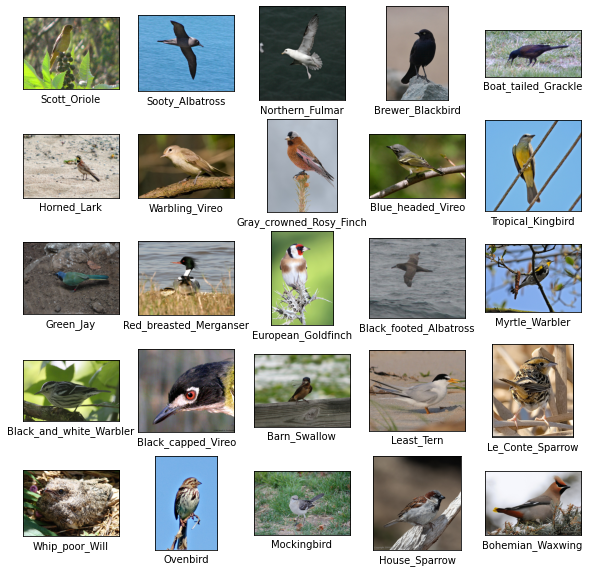

In [7]:
#testing imported data
print(data.images)
print(data.classes)
print(data.image_class_labels)
print(data.bounding_boxes)
print(data.train_test_split)
plot_grid_imgs(data.images.image_id)


# Data processing

In [8]:

# Python program to get average of a list
def Average(lst):
    return sum(lst) / len(lst)


heights = []
widths = []
def get_dims():
  for img_id in tq.tqdm(data.images.image_id):
    img = get_cv2_image(img_id)
    height, width, channels = img.shape
    heights.append(height)
    widths.append(height)
def show_dims():
  print(min(heights))
  print(min(widths))
  print(Average(heights))
  print(Average(widths))
#get_dims()
#show_dims()

In [9]:
def bound_image(img_id):
    img = get_cv2_image(img_id)
    bounding_box = get_bounding_box(img_id)
    #print(img_id,bounding_box)
    x = bounding_box.x.values[0]
    y = bounding_box.y.values[0]
    w = bounding_box.width.values[0]
    h = bounding_box.height.values[0]
    max_dim = max(w, h)
    w_diff = math.floor((w - max_dim)/2)
    h_diff = math.floor((h - max_dim)/2)
    x_srt = x+w_diff
    x_end = x+max_dim
    y_srt = y+h_diff
    y_end = y+max_dim
    if x_srt < 0:
      x_srt = x_srt - x_srt
      x_end = x_end - x_srt
    if y_srt < 0:
      y_srt = x_srt - x_srt
      y_end = x_end - x_srt
    #print(x_srt,x_end,y_srt,y_end)
    crop_img = img[y_srt:y_end,x_srt:x_end] #crops the image with respect to bounding boxes mentioned in the dataset
    return crop_img

def bound_images(image_ids, image_size):
    for img_id in tq.tqdm(image_ids):
        new_path = get_image_path(img_id,bound_fldr)
        #check if already processed
        if check_create_image_loc(new_path):
          cur_img = bound_image(img_id)
          #height, width, channels = cur_img.shape
          #max_dim = max(height, width)
          #width_new = math.floor(image_size/max_dim * width)
          #height_new = math.floor(image_size/max_dim * height)
          #print(width_new, height_new)
          #resize_img = cv2.resize(cur_img, (image_size, image_size)) #resizing the cropped image so that all images have same dimensions and can easily be converted to np array 
          #also reduces the memory usage
          #took the average of all images to rezise (mean of x+width, y+height)
          #save picture to a new path
          cv2.imwrite(new_path ,cur_img)


bound_images(data.images.image_id, image_size)

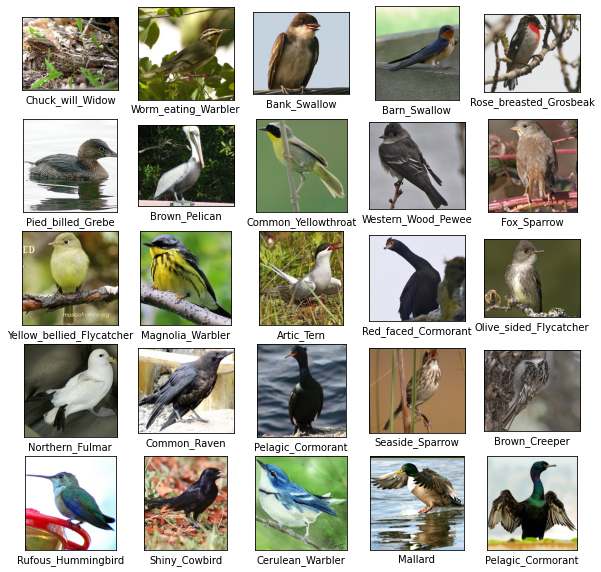

In [10]:
plot_grid_imgs(data.images.image_id, [bound_fldr])

# datasets

In [11]:
categorical_ids = [str(i-1) for i in data.classes.class_id] #data.classes.class_id.to_list()
def get_dataset(subset):
  return keras.preprocessing.image_dataset_from_directory(
    bound_fldr, labels='inferred', label_mode='categorical', class_names=categorical_ids,
    color_mode='rgb', image_size=(image_size,image_size), smart_resize=True,
    validation_split=0.2, subset=subset, 
    shuffle=True, seed=123)

In [12]:
train_ds = get_dataset('training')
temp_ds = get_dataset('validation')
dev_ds = temp_ds.shard(2, 0)
test_ds = temp_ds.shard(2, 1)

Found 11788 files belonging to 200 classes.
Using 9431 files for training.
Found 11788 files belonging to 200 classes.
Using 2357 files for validation.


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#dev_ds = dev_ds.cache().prefetch(buffer_size=AUTOTUNE)
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

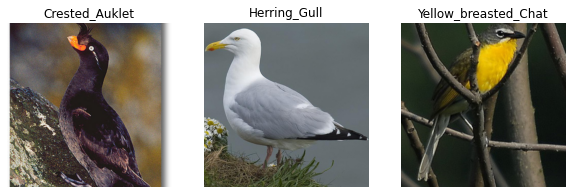

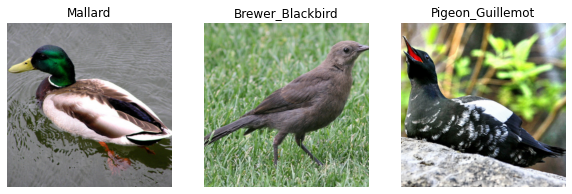

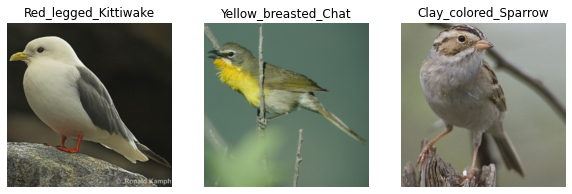

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(get_class_name(np.argmax(labels[i])+1))
    plt.axis("off")
plt.figure(figsize=(10, 10))
for images, labels in dev_ds.take(1):
  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(get_class_name(np.argmax(labels[i])+1))
    plt.axis("off")
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(get_class_name(np.argmax(labels[i])+1))
    plt.axis("off")

# Implimentation

In [23]:
def log_loc():
  return "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"

def create_checkpoint(name):
  path = name + '_best_model.hdf5'
  return ModelCheckpoint(filepath=path,
                              monitor='val_loss',
                              verbose=2, 
                              save_best_only=True,
                              mode='min')
def create_tensorboard(logdir):
  # Define the Keras TensorBoard callback.
  return keras.callbacks.TensorBoard(log_dir=logdir+ "fit/")


def build_model(num_classes, img_size, name, img_augmentation,net,optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = img_augmentation(inputs)
    #EfficientNetB0 	224
    #EfficientNetB1 	240
    #EfficientNetB2 	260
    #EfficientNetB3 	300
    #EfficientNetB4 	380
    #EfficientNetB5 	456
    #EfficientNetB6 	528
    #EfficientNetB7 	600
    
    model = net(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the exisiting models weights
    model.trainable = False

    # Create new top layers
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout = 0.2
    x = layers.Dropout(top_dropout, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # finalise and complie the model
    model = tf.keras.Model(inputs, outputs, name=name + "_EfficientNet5")
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

def unfreeze_model(model,optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)):
    # Unfreeze the top 60 layers ignoring BatchNorm layers
    for layer in model.layers[-60:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
def plot_hist(hist):
  val_accuracy = hist.history['val_accuracy']
  accuracy = hist.history['accuracy']

  plt.plot(accuracy, label='accuracy')
  plt.plot(val_accuracy, label = 'val_accuracy')

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0, 1])
  plt.legend(["Train", "Validation"], loc="upper left")

def model_acc(model,ds):
  test_loss, test_acc = model.evaluate(ds, verbose=2)
  print(test_loss,test_acc)

def transfer_learning_stage1(model,log_path, batch_size=100, epochs=10):
  tensorboard = create_tensorboard(log_path)
  checkpoint = create_checkpoint(model.name+"_stage1")
  
  hist = model.fit(train_ds, batch_size=batch_size, epochs=epochs, validation_data=dev_ds, callbacks=[tensorboard,checkpoint])

  plot_hist(hist)
  model_acc(model, test_ds)
  #%tensorboard --log_path logs
  return hist

def transfer_learning_stage2(model,log_path, batch_size=100, epochs=10, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)):
  tensorboard = create_tensorboard(log_path)
  checkpoint = create_checkpoint(model.name+"_stage2")
  
  unfreeze_model(model,optimizer=optimizer)

  hist = model.fit(train_ds, batch_size=batch_size, epochs=epochs, validation_data=dev_ds, callbacks=[tensorboard,checkpoint])

  plot_hist(hist)
  model_acc(model, test_ds)
  #%tensorboard --log_path logs
  return hist


In [20]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [21]:
optimizer = keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, decay=0.01)
#optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2)
model_B5_b =  build_model(len(categorical_ids),image_size,'model_B5_b',img_augmentation,keras.applications.EfficientNetB5,optimizer)
model_B5_b.summary()

Model: "model_B5_b_EfficientNet5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 456, 456, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 456, 456, 3)  0           img_augmentation[0][0]           
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 456, 456, 3)  7           rescaling_1[0][0]                
___________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/10
295/295 [==============================] - 204s 651ms/step - loss: 2.6405 - accuracy: 0.3874 - val_loss: 1.6450 - val_accuracy: 0.6647

Epoch 00001: val_loss improved from inf to 1.64498, saving model to model_B5_b_EfficientNet5_stage1_best_model.hdf5
Epoch 2/10
295/295 [==============================] - 188s 637ms/step - loss: 1.3651 - accuracy: 0.6344 - val_loss: 1.1134 - val_accuracy: 0.7044

Epoch 00002: val_loss improved from 1.64498 to 1.11339, saving model to model_B5_b_EfficientNet5_stage1_best_model.hdf5
Epoch 3/10
295/295 [==============================] - 188s 636ms/step - loss: 1.1618 - accuracy: 0.6819 - val_loss: 1.0540 - val_accuracy: 0.7306

Epoch 00003: val_loss improved from 1.11339 to 1.05398, saving model to model_B5_b_EfficientNet5_stage1_best_model.hdf5
Epoch 4/10
295/295 [==============================] - 188s 636ms/step - loss: 1.0761 - accuracy: 0.7099 - val_loss: 0.9671 - val_accuracy: 0.7441

Epoch 00004: val_loss improved from 1.05398 to 0.96707, 

UsageError: Line magic function `%tensorboard` not found.


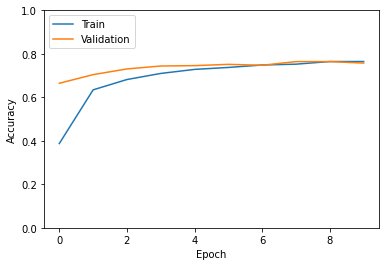

In [22]:
log_path = log_loc()
history_B5_b1 = transfer_learning_stage1(model_B5_b, log_path, batch_size=100, epochs=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/10
295/295 [==============================] - 234s 748ms/step - loss: 0.7971 - accuracy: 0.7740 - val_loss: 0.7516 - val_accuracy: 0.7889

Epoch 00001: val_loss improved from inf to 0.75163, saving model to model_B5_b_EfficientNet5_stage2_best_model.hdf5
Epoch 2/10
295/295 [==============================] - 216s 731ms/step - loss: 0.7182 - accuracy: 0.7980 - val_loss: 0.7471 - val_accuracy: 0.7846

Epoch 00002: val_loss improved from 0.75163 to 0.74710, saving model to model_B5_b_EfficientNet5_stage2_best_model.hdf5
Epoch 3/10
295/295 [==============================] - 216s 731ms/step - loss: 0.6930 - accuracy: 0.8081 - val_loss: 0.7543 - val_accuracy: 0.7855

Epoch 00003: val_loss did not improve from 0.74710
Epoch 4/10
295/295 [==============================] - 216s 731ms/step - loss: 0.6587 - accuracy: 0.8193 - val_loss: 0.7282 - val_accuracy: 0.8024

Epoch 00004: val_loss improved from 0.74710 to 0.72821, saving model to model_B5_b_EfficientNet5_stage2_best_model.hdf5
Epoch

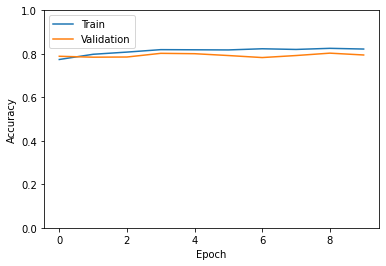

In [24]:
optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, decay=0.01)
#optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
history_B5_b2 = transfer_learning_stage2(model_B5_b, log_path, batch_size=100, epochs=10,optimizer=optimizer)

In [25]:
model_acc(model_B5_b,dev_ds)

37/37 - 23s - loss: 0.7118 - accuracy: 0.8049
0.7117995619773865 0.8048986196517944


In [26]:
model_acc(model_B5_b,test_ds)

37/37 - 22s - loss: 0.6682 - accuracy: 0.8159
0.6681727170944214 0.8158567547798157


In [30]:
def flatten(listOfLists):
    "Flatten one level of nesting"
    return list(itertools.chain.from_iterable(listOfLists))

In [31]:
dev_pred_cats = []
dev_gold_cats = []
for batch_images, batch_labels in dev_ds:
  batch_pred = model_B5_b.predict(batch_images)
  dev_pred_cats.append(np.argmax(batch_pred, axis=1))
  dev_gold_cats.append(np.argmax(batch_labels, axis=1))

dev_gold_ids = flatten(dev_pred_cats)
dev_pred_ids = flatten(dev_gold_cats)

print(dev_gold_ids)
print(dev_pred_ids)

dev_gold = [get_class_name(x+1) for x in dev_gold_ids]
dev_pred = [get_class_name(x+1) for x in dev_pred_ids]

print("\nDev set classification report")
print(sklearn.metrics.classification_report(dev_gold,dev_pred))

[68, 62, 9, 121, 111, 31, 11, 68, 41, 85, 159, 30, 29, 10, 81, 189, 122, 127, 91, 80, 17, 152, 101, 186, 182, 164, 22, 89, 144, 128, 13, 0, 184, 19, 57, 168, 102, 78, 199, 140, 23, 64, 24, 112, 23, 114, 152, 43, 28, 177, 72, 12, 177, 86, 18, 35, 87, 37, 39, 166, 28, 44, 149, 166, 55, 77, 29, 77, 38, 43, 162, 46, 75, 153, 105, 179, 42, 131, 114, 0, 98, 145, 62, 95, 53, 108, 154, 71, 130, 36, 102, 35, 162, 77, 60, 150, 158, 10, 170, 42, 79, 29, 40, 120, 64, 109, 78, 19, 118, 68, 62, 13, 121, 119, 169, 131, 174, 31, 72, 118, 182, 103, 50, 145, 160, 42, 99, 90, 16, 135, 119, 48, 42, 21, 134, 38, 126, 15, 39, 60, 189, 95, 115, 175, 44, 38, 74, 8, 188, 145, 54, 192, 124, 196, 86, 8, 20, 167, 44, 49, 123, 3, 70, 75, 183, 90, 21, 78, 168, 13, 96, 61, 73, 40, 180, 69, 1, 168, 75, 84, 179, 116, 26, 71, 166, 54, 174, 40, 177, 39, 34, 37, 112, 44, 56, 43, 193, 60, 137, 32, 67, 56, 165, 113, 110, 152, 121, 139, 76, 193, 33, 196, 66, 6, 100, 87, 114, 121, 197, 56, 105, 105, 162, 177, 124, 28, 84, 15

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
test_pred_cats = []
test_gold_cats = []
for batch_images, batch_labels in test_ds:
  batch_pred = model_B5_b.predict(batch_images)
  test_pred_cats.append(np.argmax(batch_pred, axis=1))
  test_gold_cats.append(np.argmax(batch_labels, axis=1))

test_gold_ids = flatten(test_pred_cats)
test_pred_ids = flatten(test_gold_cats)

print(test_gold_ids)
print(test_pred_ids)

test_gold = [get_class_name(x+1) for x in test_gold_ids]
test_pred = [get_class_name(x+1) for x in test_pred_ids]

print("\nTest set classification report")
print(sklearn.metrics.classification_report(test_gold, test_pred))

[116, 54, 34, 175, 110, 10, 165, 20, 164, 33, 175, 87, 101, 67, 189, 84, 128, 7, 14, 76, 22, 0, 39, 109, 89, 90, 33, 168, 170, 126, 180, 30, 174, 109, 147, 8, 190, 19, 127, 168, 74, 148, 81, 127, 147, 18, 72, 79, 135, 81, 136, 177, 78, 121, 122, 156, 146, 163, 170, 60, 41, 169, 39, 171, 187, 44, 105, 122, 182, 184, 114, 182, 112, 20, 27, 88, 31, 174, 75, 44, 149, 62, 10, 15, 22, 150, 102, 0, 62, 44, 17, 130, 190, 7, 123, 179, 71, 31, 38, 161, 148, 189, 48, 62, 64, 96, 124, 10, 55, 62, 28, 172, 122, 195, 135, 22, 159, 72, 162, 13, 144, 115, 198, 193, 67, 8, 118, 123, 22, 87, 77, 165, 196, 60, 166, 186, 196, 49, 43, 183, 9, 51, 133, 179, 171, 161, 112, 158, 126, 128, 168, 167, 103, 125, 138, 114, 53, 167, 52, 0, 33, 105, 39, 179, 70, 154, 89, 145, 33, 180, 199, 107, 181, 69, 68, 196, 97, 18, 70, 32, 74, 53, 179, 3, 100, 49, 22, 120, 50, 180, 75, 46, 188, 160, 10, 93, 165, 7, 37, 68, 159, 61, 94, 29, 4, 7, 87, 65, 98, 79, 32, 60, 175, 72, 129, 131, 159, 135, 13, 189, 95, 160, 53, 44, 4, 2

[[6 0 1 ... 0 0 0]
 [2 4 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 6 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 5]]
[[5 0 0 ... 0 0 0]
 [1 4 0 ... 0 0 0]
 [1 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 6]]


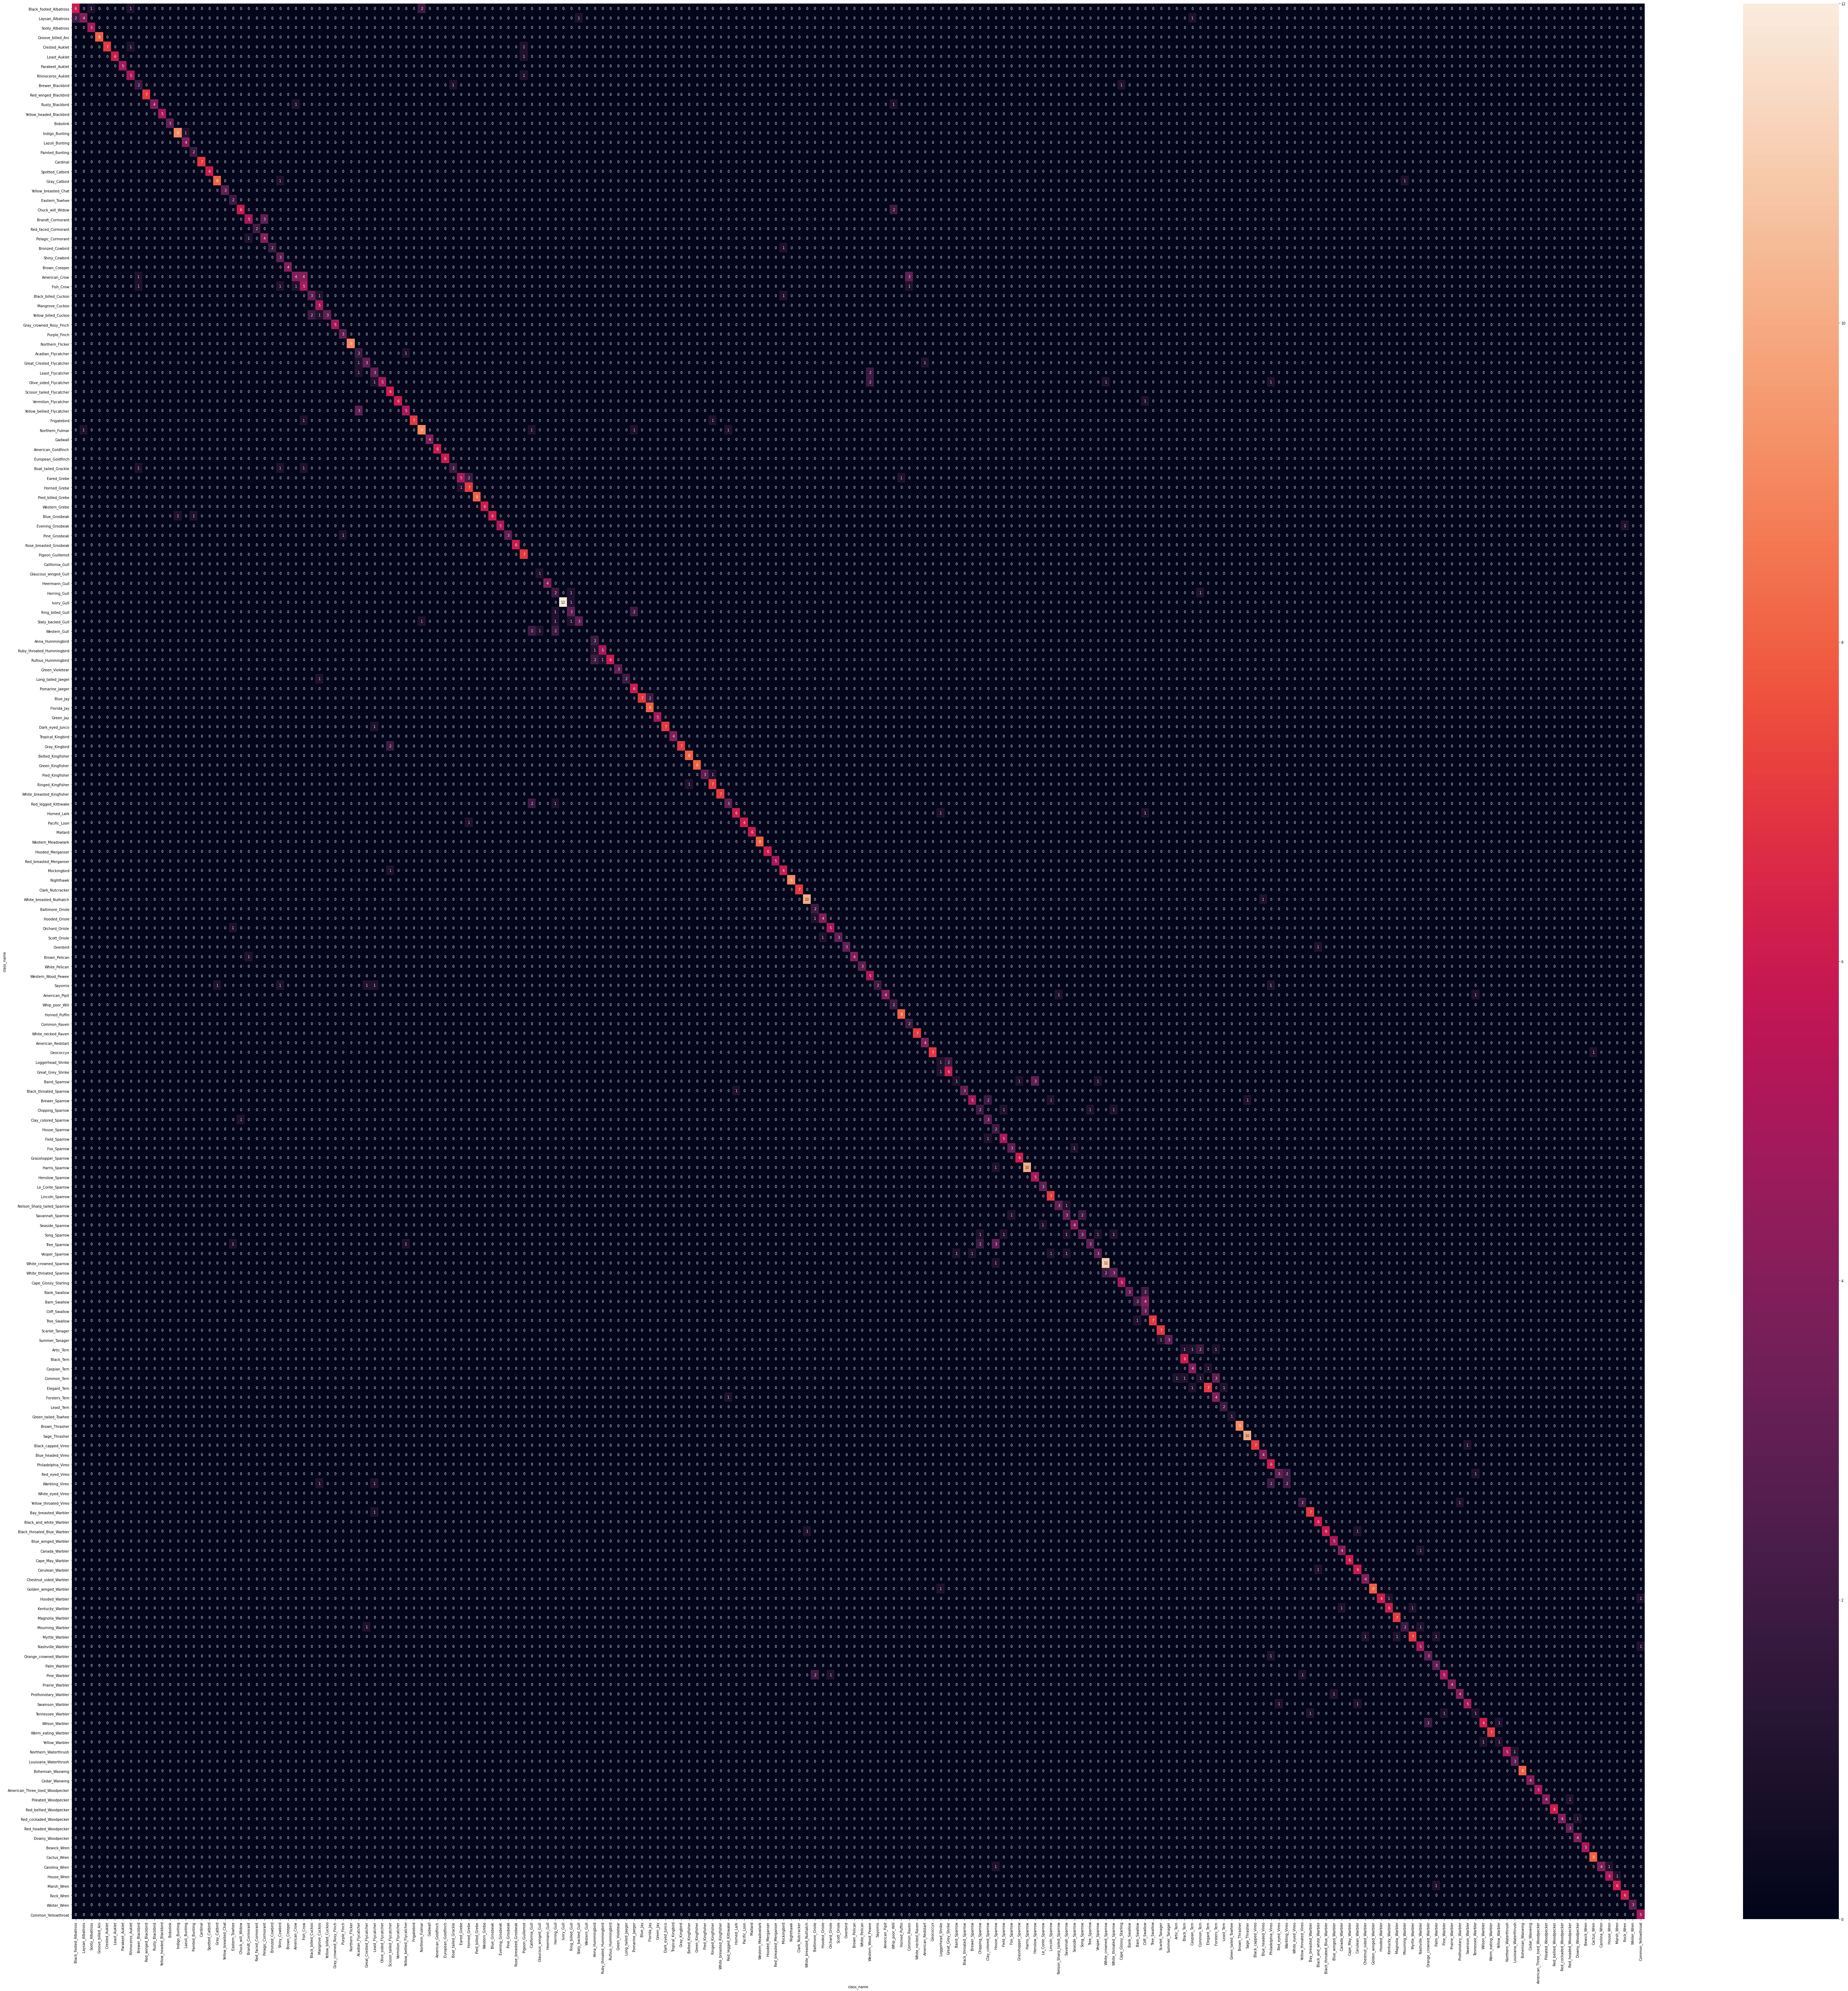

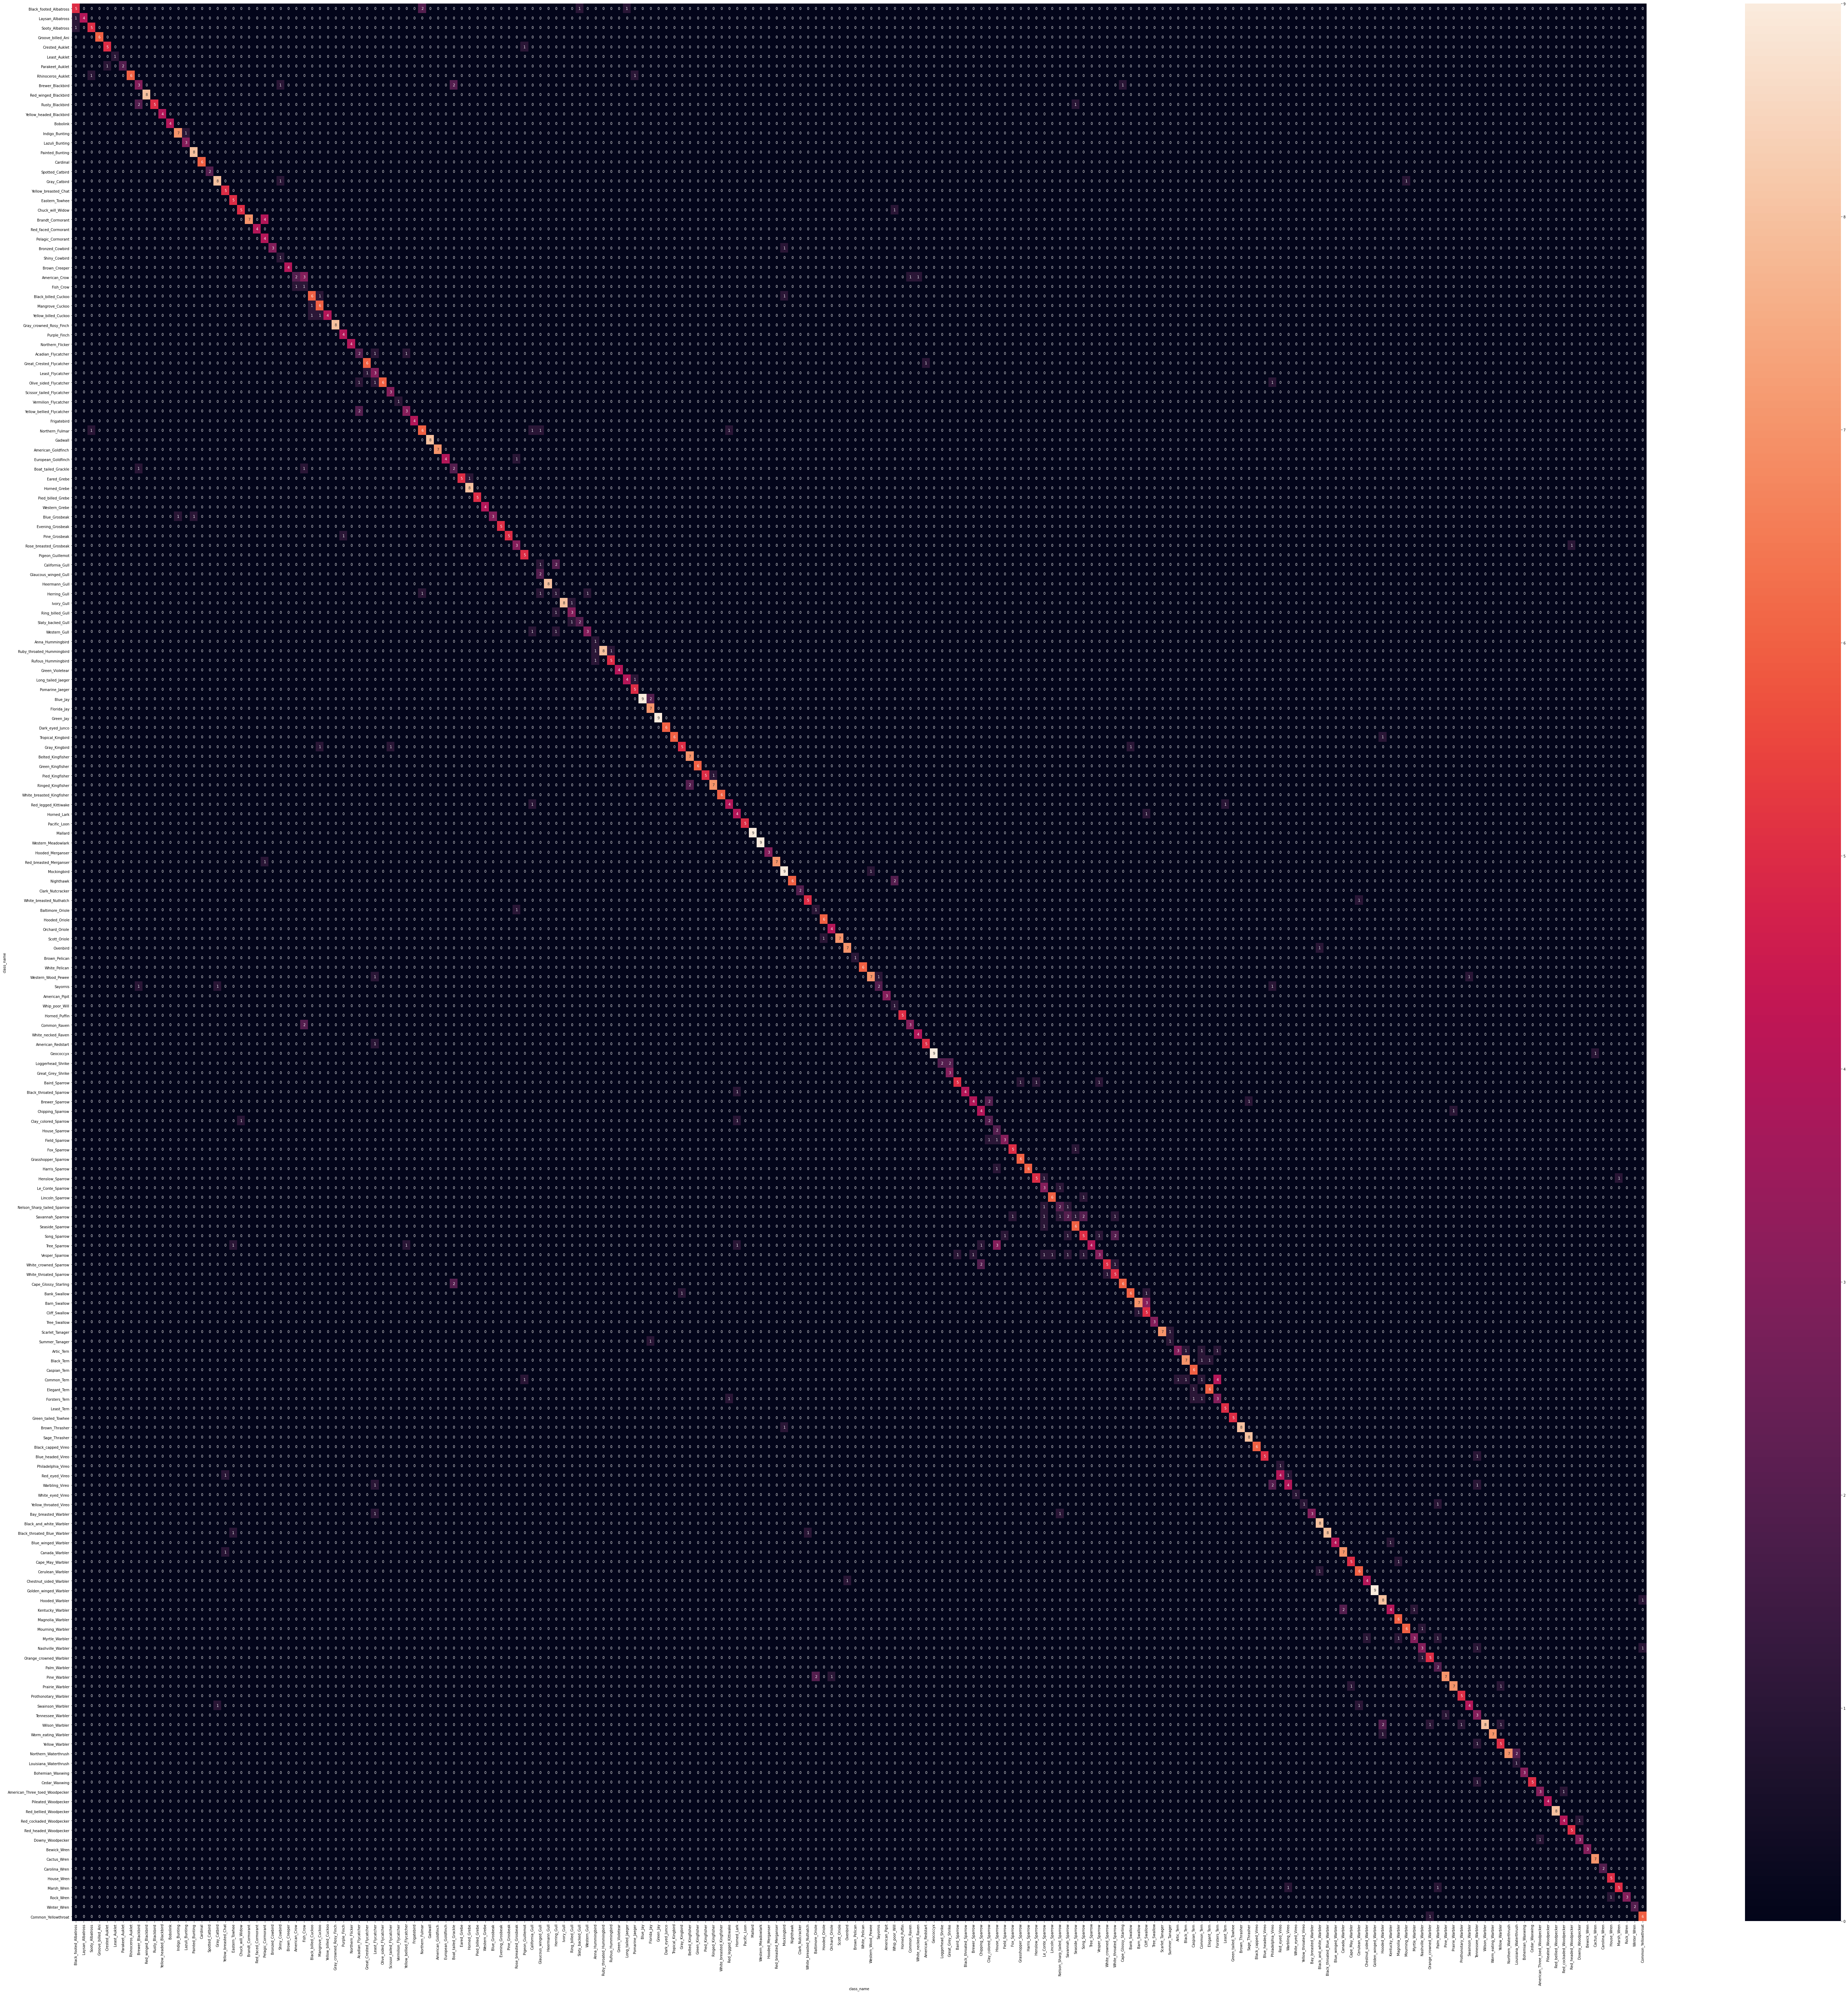

In [33]:
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

classifier = estimator(model_B5_b, data.classes.class_name)

dev_cm = tf.math.confusion_matrix(dev_gold_ids,dev_pred_ids)
dev_cm_arr =  np.array(dev_cm)

print(dev_cm_arr)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(dev_cm_arr, index = data.classes.class_name,
                  columns = data.classes.class_name)
plt.figure(figsize = (100,100))
sn.heatmap(df_cm, annot=True)

#dev_cm_plt = sklearn.metrics.plot_confusion_matrix(classifier,dev_ds,dev_gold_ids)
#dev_cm_plt.ax_.set_title("Dev set confusion matrix")

#test_cm =tf.math.confusion_matrix(test_gold,test_pred)
#print(test_cm)

test_cm = tf.math.confusion_matrix(test_gold_ids,test_pred_ids)
test_cm_arr =  np.array(test_cm)

print(test_cm_arr)


df2_cm = pd.DataFrame(test_cm_arr, index = data.classes.class_name,
                  columns = data.classes.class_name)
plt.figure(figsize = (100,100))
sn.heatmap(df2_cm, annot=True)

#test_cm_plt = sklearn.metrics.plot_confusion_matrix(classifier,test_ds,test_gold)
#test_cm_plt.ax_.set_title("Test set confusion matrix")

